In [2]:
from stage1 import *

NameError: name '_C' is not defined

In [ ]:
nframes,natoms,nmols=(0,0,0)

In [ ]:
from stage2 import * 

In [ ]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [ ]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [ ]:
cf=condenseframe(testframe)

In [ ]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [ ]:
cf

array([[ 9.89732184e+02, -1.19746289e+02, -1.97409429e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 9.89768499e+02, -1.19735860e+02, -1.97410766e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 9.89681805e+02, -1.19738573e+02, -1.97401416e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 9.89936113e+02, -1.19777279e+02, -1.97450172e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 9.89917252e+02, -1.19778816e+02, -1.97441199e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 9.89954919e+02, -1.19774158e+02, -1.97441629e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [ ]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:01<00:00, 28.49it/s]

30192


In [ ]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [ ]:
g = get_graph(cf,1,n_neigh,"cry")

In [ ]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [ ]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 500
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [ ]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:01<00:00, 24232.10it/s]


In [ ]:
graphs = graphs_device
total_graphs = len(graphs)


In [ ]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [ ]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [ ]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [ ]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [ ]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 130147.4899
	Test: 	MSE Loss: 114802.5309
Epoch: 002
	Train:	MSE Loss: 51443.5546
	Test: 	MSE Loss: 29837.0739
Epoch: 003
	Train:	MSE Loss: 24405.0024
	Test: 	MSE Loss: 17514.1424
Epoch: 004
	Train:	MSE Loss: 13349.2459
	Test: 	MSE Loss: 9128.8903
Epoch: 005
	Train:	MSE Loss: 7737.0462
	Test: 	MSE Loss: 6915.7108
Epoch: 006
	Train:	MSE Loss: 6664.8139
	Test: 	MSE Loss: 6391.6401
Epoch: 007
	Train:	MSE Loss: 6122.7693
	Test: 	MSE Loss: 5809.9214
Epoch: 008
	Train:	MSE Loss: 5333.2645
	Test: 	MSE Loss: 4734.2436
Epoch: 009
	Train:	MSE Loss: 3686.2963
	Test: 	MSE Loss: 2341.0641
Epoch: 010
	Train:	MSE Loss: 1060.4954
	Test: 	MSE Loss: 523.9013
Epoch: 011
	Train:	MSE Loss: 409.1049
	Test: 	MSE Loss: 292.7582
Epoch: 012
	Train:	MSE Loss: 243.2883
	Test: 	MSE Loss: 179.7843
Epoch: 013
	Train:	MSE Loss: 151.7823
	Test: 	MSE Loss: 111.9683
Epoch: 014
	Train:	MSE Loss: 97.2036
	Test: 	MSE Loss: 73.7036
Epoch: 015
	Train:	MSE Loss: 65.8007
	Test: 	MSE Loss: 51.9607
E

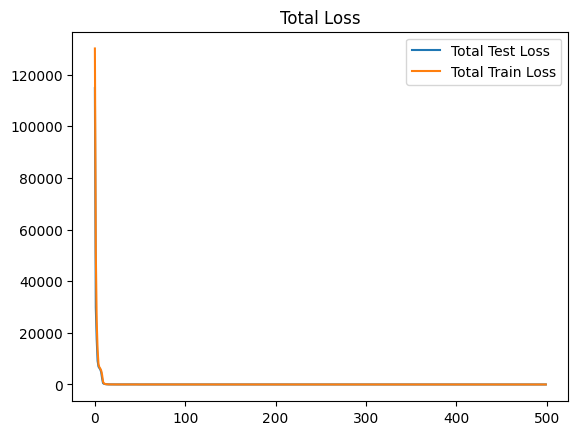

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

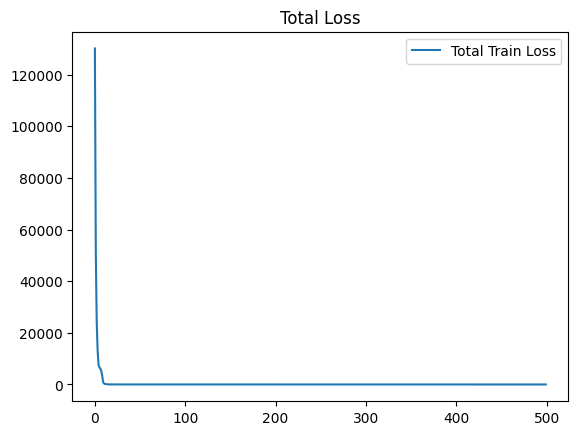

In [ ]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

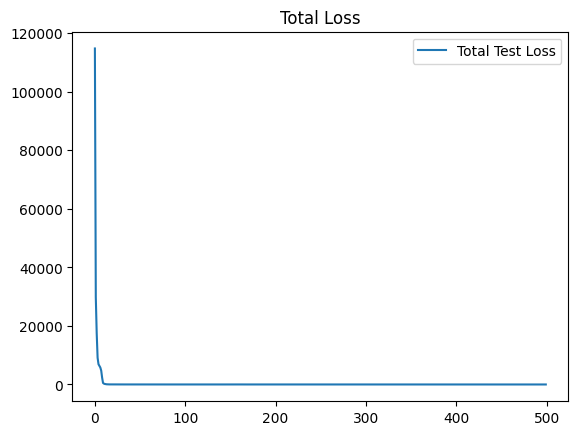

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [ ]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 7.195925352075141


In [ ]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [ ]:
input_feature[0][heavy_indices]

tensor([[ 9.8873e+02, -1.1966e+02, -1.9725e+02,  1.5950e+00,  1.8720e+01,
          1.3198e+01],
        [ 9.9083e+02, -1.1989e+02, -1.9766e+02,  3.0450e+00,  1.9585e+01,
          1.5307e+01],
        [ 9.8990e+02, -1.1972e+02, -1.9749e+02,  2.7775e+00,  1.6788e+01,
          1.1465e+01],
        [ 9.8948e+02, -1.1965e+02, -1.9747e+02,  3.9550e+00,  1.6875e+01,
          1.4888e+01],
        [ 9.9007e+02, -1.1989e+02, -1.9745e+02,  3.9250e-01,  1.7743e+01,
          1.0063e+01],
        [ 9.8921e+02, -1.1959e+02, -1.9720e+02,  1.4700e+00,  1.4990e+01,
          1.4305e+01],
        [ 9.8944e+02, -1.1968e+02, -1.9730e+02,  9.5000e-02,  2.0290e+01,
          1.6618e+01],
        [ 9.9034e+02, -1.1987e+02, -1.9754e+02,  3.5950e+00,  2.2160e+01,
          1.4565e+01],
        [ 9.8888e+02, -1.1968e+02, -1.9731e+02,  5.6675e+00,  2.0110e+01,
          1.3820e+01],
        [ 9.8951e+02, -1.1974e+02, -1.9734e+02,  5.9825e+00,  1.7610e+01,
          1.3267e+01],
        [ 9.8819e+02, -1.1941e

In [ ]:
decoded_feature[0][heavy_indices]

tensor([[ 988.8522, -119.5020, -197.0211,    6.9363,   15.6108,   15.8727],
        [ 988.8785, -119.6446, -197.2681,    6.6293,   18.5765,   18.8631],
        [ 988.8809, -119.6448, -197.2683,    6.6292,   18.4961,   18.8645],
        [ 988.8808, -119.6448, -197.2683,    6.6292,   18.4974,   18.8645],
        [ 988.8808, -119.6448, -197.2683,    6.6292,   18.4991,   18.8645],
        [ 988.8802, -119.6447, -197.2682,    6.6292,   18.5183,   18.8641],
        [ 988.8809, -119.6448, -197.2683,    6.6292,   18.4932,   18.8646],
        [ 988.8795, -119.6447, -197.2682,    6.6293,   18.5413,   18.8637],
        [ 988.8760, -119.6444, -197.2679,    6.6295,   18.6624,   18.8616],
        [ 988.8809, -119.6448, -197.2683,    6.6292,   18.4951,   18.8646],
        [ 988.8809, -119.6448, -197.2683,    6.6292,   18.4940,   18.8646],
        [ 988.8807, -119.6448, -197.2683,    6.6292,   18.5014,   18.8644],
        [ 988.8794, -119.6447, -197.2682,    6.6293,   18.5449,   18.8637],
        [ 98

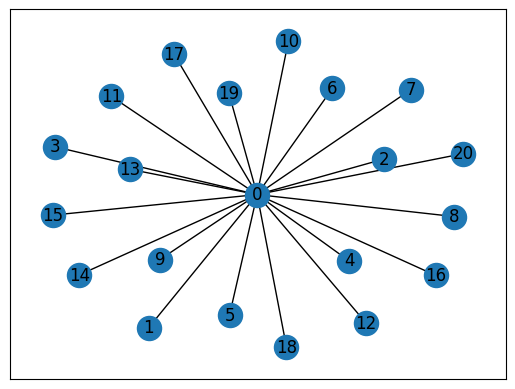

In [ ]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
